## Before running this notebook, you must have already the numerically simulated waves associated to the representative cases of synthetic simulated TCs (obtained with MaxDiss algorithm in notebook 06)

inputs required: 
  * Synthetic simulation of historical TCs parameters (copulas obtained in notebook 06)
  * MaxDiss selection of synthetic simulated TCs (parameters obtained in notebook 06)
  * simulated waves for the above selected TCs (**outside TeslaKit**)

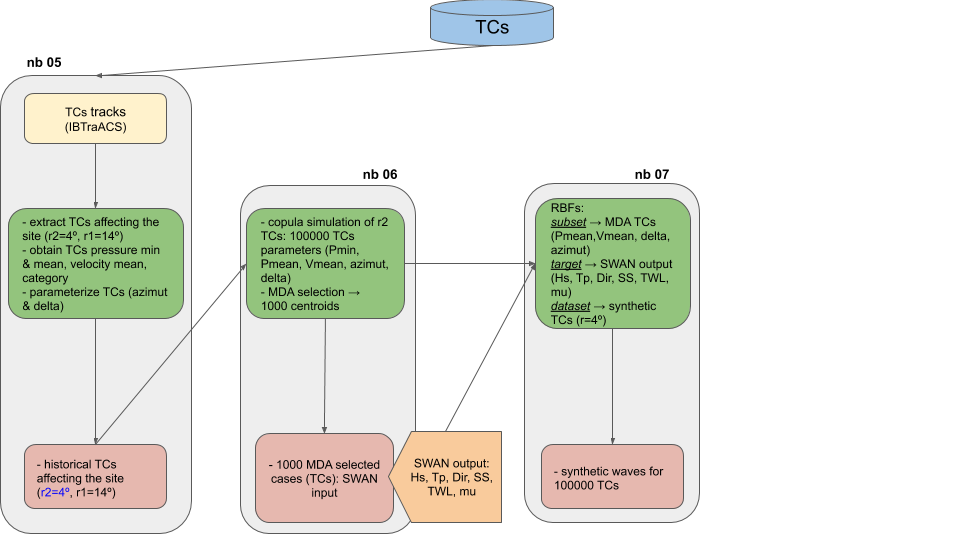

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import xarray as xr
import numpy as np

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.io.matlab import ReadMatfile
from teslakit.rbf import RBF_Reconstruction, RBF_Validation



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')
           

In [3]:
# --------------------------------------
# load data and set parameters

# TCs copula simulated (dataset) and TCs MDA selection
dataset = db.Load_TCs_r2_sim_params()
subset = db.Load_TCs_r2_mda_params()

# r2 mda TCs solved simulations (not solved inside teslakit)
TCs_sims = db.Load_TCs_r2_mda_Simulations()


In [4]:
# --------------------------------------
# load custom RBFs training subset and dataset to interpolate

# TODO: our datasets (db.Load_TCs_r2_sim_params and db.Load_TCs_r2_mda_params) 
# do not match with currently stored solved simulations.

# we are using matching matlab files for KWAJALEIN TCs simulations
# (overriding subset so it matches solved target)
p_test = op.join(p_data, 'tests', 'RBF')
p_subset = op.join(p_test, 'MDA_1000.mat')
p_dataset = op.join(p_test, 'MULTIVARIATE_100000parameters.mat')

# load subset data
subset = ReadMatfile(p_subset)['Subset']  # pmean, vmean, gamma, delta

# load full dataset for interpolation
dm = ReadMatfile(p_dataset)
dataset = np.column_stack(
    (dm['PMEAN1'], dm['VMEAN'], dm['GAMMA'], dm['DELTA'])
)



## Simulated TCs -  Radial Basis Function

In [5]:
# --------------------------------------
# Extract waves data from TCs simulations (this is the RBFs training target)

print(TCs_sims)
print()

# Normalize data
d_maxis = {}
d_minis = {}
tcp = TCs_sims.copy()
for k in ['hs', 'tp', 'ss', 'twl']:
    v = tcp[k].values[:]
    mx = np.max(v)
    mn = np.min(v)
    tcp[k] =(('storm',), (v-mn)/(mx-mn))
    
    # store maxs and mins for denormalization
    d_maxis[k] = mx
    d_minis[k] = mn

tcp['dir'] = tcp['dir'] * np.pi/180
    
print(tcp)
print()


# Build RBF target numpy array
target = np.column_stack(
    (tcp['hs'], tcp['tp'], tcp['ss'], tcp['twl'], tcp['dir'], tcp['mu'])
)


<xarray.Dataset>
Dimensions:  (storm: 1000)
Coordinates:
  * storm    (storm) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Data variables:
    hs       (storm) float64 0.13 0.026 4.398 1.352 ... 1.782 8.078 5.11 6.136
    tp       (storm) float64 3.61 1.506 14.71 9.259 ... 6.494 13.16 11.9 13.33
    dir      (storm) float64 42.4 45.0 124.2 267.3 13.2 ... 35.2 23.5 90.0 122.3
    ss       (storm) float64 0.005154 0.007572 0.09592 ... 0.1987 0.07206 0.1122
    twl      (storm) float64 0.07414 0.02044 1.73 0.5898 ... 2.181 1.498 1.863
    mu       (storm) float64 0.7074 0.8419 0.805 0.9491 ... 0.623 0.5043 0.6556

<xarray.Dataset>
Dimensions:  (storm: 1000)
Coordinates:
  * storm    (storm) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Data variables:
    hs       (storm) float64 0.009134 0.001473 0.3235 ... 0.5946 0.376 0.4515
    tp       (storm) float64 0.1312 0.0 0.823 0.4834 ... 0.7265 0.6484 0.7375
    dir      (storm) float64 0.74 0.7854 2.168 4.665 ...

In [6]:
# --------------------------------------
# RBF Interpolation

# subset - scalar / directional indexes
ix_scalar_subset = [0,1]        # scalar (pmean,  vmean)
ix_directional_subset = [2,3]   # directional (delta, gamma)

# target - scalar / directional indexes
ix_scalar_target = [0,1,2,3,5]  # scalar (Hs, Tp, SS, TWL, MU)
ix_directional_target = [4]     # directional (Dir)

output = RBF_Reconstruction(
    subset, ix_scalar_subset, ix_directional_subset,
    target, ix_scalar_target, ix_directional_target,
    dataset)


ix_scalar: 0,  optimization: 179.69 | interpolation: 17.28
ix_scalar: 1,  optimization: 128.50 | interpolation: 17.61
ix_scalar: 2,  optimization: 219.67 | interpolation: 15.59
ix_scalar: 3,  optimization: 145.60 | interpolation: 16.49
ix_scalar: 5,  optimization: 147.49 | interpolation: 18.25
ix_directional: 4,  optimization: 374.29 | interpolation: 34.11


In [7]:
# --------------------------------------
# Reconstructed TCs

# denormalize RBF output
TCs_RBF_out = xr.Dataset(
    {
        'hs':(('storm',), output[:,0] * (d_maxis['hs']-d_minis['hs']) + d_minis['hs'] ),
        'tp':(('storm',), output[:,1] * (d_maxis['tp']-d_minis['tp']) + d_minis['tp'] ),
        'ss':(('storm',), output[:,2] * (d_maxis['ss']-d_minis['ss']) + d_minis['ss'] ),
        'twl':(('storm',), output[:,3] * (d_maxis['twl']-d_minis['twl']) + d_minis['twl'] ),
        'dir':(('storm',), output[:,4] * 180 / np.pi),
        'mu':(('storm',), output[:,5]),
    },
    coords = {'storm': np.arange(output.shape[0])}
)
print(TCs_RBF_out)

# store data as xarray.Dataset
db.Save_TCs_sim_r2_rbf_output(TCs_RBF_out)


<xarray.Dataset>
Dimensions:  (storm: 100000)
Coordinates:
  * storm    (storm) int64 0 1 2 3 4 5 6 ... 99994 99995 99996 99997 99998 99999
Data variables:
    hs       (storm) float64 6.488 2.125 2.428 2.505 ... 5.623 2.632 1.791 3.593
    tp       (storm) float64 12.24 10.92 7.623 10.04 ... 12.79 7.024 8.28 9.868
    ss       (storm) float64 0.1163 0.0632 0.018 ... 0.1009 0.04997 0.1177
    twl      (storm) float64 1.671 0.8837 0.6813 0.82 ... 0.6608 0.6022 1.141
    dir      (storm) float64 95.05 82.92 66.62 111.1 ... 114.1 61.17 88.9 98.49
    mu       (storm) float64 0.6176 0.6227 0.8581 0.725 ... 0.7585 0.7668 0.4756


In [8]:
# --------------------------------------
# RBF Validation

# subset - scalar / directional indexes
ix_scalar_subset = [0,1]        # scalar (pmean,  vmean)
ix_directional_subset = [2,3]   # directional (delta, gamma)

# target - scalar / directional indexes
ix_scalar_target = [0,1,2,3,5]  # scalar (Hs, Tp, SS, TWL, MU)
ix_directional_target = [4]     # directional (Dir)

output = RBF_Validation(
    subset, ix_scalar_subset, ix_directional_subset,
    target, ix_scalar_target, ix_directional_target)


RBFs Kfold Validation: 1/3
ix_scalar: 0,  optimization: 60.73 | interpolation: 0.04
ix_scalar: 1,  optimization: 51.83 | interpolation: 0.04
ix_scalar: 2,  optimization: 73.29 | interpolation: 0.04
ix_scalar: 3,  optimization: 56.44 | interpolation: 0.04
ix_scalar: 5,  optimization: 76.64 | interpolation: 0.04
ix_directional: 4,  optimization: 140.06 | interpolation: 0.10
mean squared error : 126.99564768105262

RBFs Kfold Validation: 2/3
ix_scalar: 0,  optimization: 51.32 | interpolation: 0.05
ix_scalar: 1,  optimization: 51.38 | interpolation: 0.04
ix_scalar: 2,  optimization: 64.24 | interpolation: 0.06
ix_scalar: 3,  optimization: 55.64 | interpolation: 0.04
ix_scalar: 5,  optimization: 83.81 | interpolation: 0.06
ix_directional: 4,  optimization: 163.55 | interpolation: 0.13
mean squared error : 62.67218334192506

RBFs Kfold Validation: 3/3
ix_scalar: 0,  optimization: 72.90 | interpolation: 0.05
ix_scalar: 1,  optimization: 75.65 | interpolation: 0.05
ix_scalar: 2,  optimization: